# Steam Search Engine - Evaluation
This document aims to evaluate the performances of the search engine through a series of measures.
The set of queries considered in the computations is defined in "queries.json".
All the measures are applied to the different verions of the project:
- base version, ranking model: BM25F;
- sentiment analysis v1: every game sentiment value is obtained from the average of its reviews sentiment values;
- sentiment analysis v2: every game sentiment value is obatined from the inverted neutral weighted average of its reviews sentiment values.

The following code retrieves the queries set and creates the Benchmarks object.

In [4]:
import os
import json
from BenchmarkUtilities.benchmarks import Benchmarks

# file containing benchmark queries
file_path = os.path.join("BenchmarkUtilities", "queries.json")

with open(file_path) as f:
    queries = json.load(f)

b = Benchmarks(queries)

NB. Per eseguire i benchmark è obbligatorio creare gli indici (indexdir/base e indexdir/sentiment) in precedenza.

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


<Axes: xlabel='standard recall levels', ylabel='precision'>

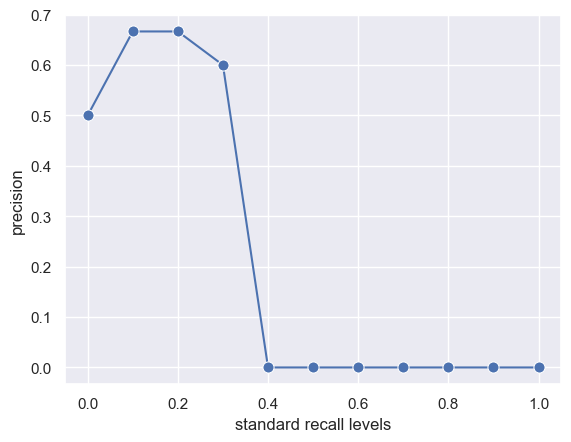

In [7]:
from whoosh.index import open_dir
from MainImplementation.GameSearcher import GameSearcher
import seaborn as sns
import pandas as pd

indexdirBase = "indexdir/base"
indexdirSentiment = "indexdir/sentiment"
if (not os.path.exists(indexdirBase) and not os.path.exists(indexdirSentiment)):
        raise Exception("Index not found")
# create the 2 index objects corresponding to the main index and the sentiment index
main_idxb, reviews_idxb = open_dir(indexdirBase + "/main_index"), open_dir(indexdirBase + "/reviews_index")
main_idxs, reviews_idxs = open_dir(indexdirSentiment + "/main_index"), open_dir(indexdirSentiment + "/reviews_index")

# there is one GameSearcher object for every version of the engine
SearcherBaseVersion = GameSearcher(main_idxb, reviews_idxb)
SearcherSentimentAV = GameSearcher(main_idxs, reviews_idxs, True, "av")
SearcherSentimentINAV = GameSearcher(main_idxs, reviews_idxs, True, "inav")

# search using the benchmark query and its fields
answerB = SearcherBaseVersion.search(b.queries[0]["query"], b.queries[0]["fields"])
answerAV = SearcherSentimentAV.search(b.queries[0]["query"], b.queries[0]["fields"])
answerINAV = SearcherSentimentINAV.search(b.queries[0]["query"], b.queries[0]["fields"])

# exctract the app_id field from the retrieved games
aB = [int(x["app_id"]) for x in answerB]
aAV = [int(x["app_id"]) for x in answerAV]
aINAV = [int(x["app_id"]) for x in answerINAV]

# compute the precision at Standard Recall Levels
pB = b.precisionSRL(b.precisionNRL(b.queries[0]["relevant_documents"], aB))
pAV = b.precisionSRL(b.precisionNRL(b.queries[0]["relevant_documents"], aAV))
pAV = b.precisionSRL(b.precisionNRL(b.queries[0]["relevant_documents"], aINAV))

# plot the computed precisions
# apply the default theme
sns.set_theme()

srl, precisionB = zip(*pB)

# create a dataframe for Seaborn
df = pd.DataFrame({'standard recall levels': srl, 'precision': precisionB})

# create a line plot
sns.lineplot(data = df, x = 'standard recall levels', y = 'precision', marker='o', markersize=8, color='b')